# Comparison: GD vs Maxvol approach for approximation (1-D case)
We need to compare approaches in the following sences:
* **Condition number** or/and **determinant** of the resulting matrix $A$ 

* Derive analytical dependence of $\det(A^{+}A)$ from $x$ – sampling interval, and use it in GD 
* ...
* Profit!

In [289]:
import numpy as np
import numpy.linalg as LA
from numpy.polynomial import Chebyshev as T
from scipy import optimize
from maxvolpy.maxvol import maxvol
import matplotlib.pyplot as plt
%matplotlib inline

In [290]:
# generate polynomial matrix 
def gen_mat(points, degree):
    num_of_columns = degree + 1
    A = np.zeros((len(points), num_of_columns), dtype = np.float64)
    for i in range(num_of_columns):
        #A[:, i] = points[:]**i #uncomment for the monomial case
        A[:, i] = T.basis(i)(points[:]) #uncomment for Chebyshev polynomials
    return A

In [291]:
# calculation of condition number
# LOSS FUNCTION 
def cond_handmade(points):
    matrix = gen_mat(points, degree)
    return ((LA.norm(matrix, 2) * LA.norm(LA.pinv(matrix), 2)) / LA.norm(matrix, 1)**2)

In [318]:
# plotting and errors of approximation

def plot_and_err(x_gd, x_maxvol, interval):
    
    # solution to the linear system
    c_gd = LA.solve(gen_mat(x_gd, degree), f(x_gd))
    c_maxvol = LA.solve(gen_mat(x_maxvol, degree), f(x_maxvol))
    
    rhs = f(interval)
    rhs_gd = np.polynomial.chebyshev.chebval(interval, c_gd)
    rhs_maxvol = np.polynomial.chebyshev.chebval(interval, c_maxvol)
    
    err_maxvol = round((LA.norm(rhs - rhs_maxvol, 2) / LA.norm(rhs, 2)), 4)
    err_gd = round((LA.norm(rhs - rhs_gd, 2) / LA.norm(rhs, 2)), 4)
    
    # plotting
    __ , axarr = plt.subplots(1, 3, figsize=(18, 5))
    
    axarr[0].grid(True)
    axarr[0].plot(interval, rhs, 'b', interval, rhs_maxvol, 'r--', x_maxvol, f(x_maxvol), 'go')
    axarr[0].set_title('Maxvol error = ' + str(err_maxvol))
    axarr[0].set_xlabel("X")
    axarr[0].set_ylabel("f(X)")
    
    axarr[1].grid(True)
    axarr[1].plot(interval, rhs, 'b', interval, rhs_gd, 'r--', x_gd, f(x_gd), 'go')
    axarr[1].set_title('GD error = ' + str(err_gd))
    axarr[1].set_xlabel("X")
    axarr[1].set_ylabel("f(X)")
    
    axarr[2].grid(True)
    axarr[2].plot(range(len(x_0)), np.sort(res[0]), 'g^', range(len(x_0)), np.sort(mat[row_indx, 1]), 'ro', label = ["asdas","d"])
    axarr[2].set_title('GD vs Maxvol')
    axarr[2].set_xlabel("N – point number")
    axarr[2].set_ylabel("X")
    
    plt.show()

# approximated function
def f(x):
    return (x**7 + 1)

In [319]:
# workplace 

degree = 4
left = -1
right = 1
num_points = degree + 1

x_0 = np.linspace(left, right, num_points) 
x_big = np.linspace(left, right, 1000000) 

bnds = tuple((left, right) for i in x_0)

#### Gradient Descent

In [320]:
res = optimize.fmin_l_bfgs_b(cond_handmade, x_0, approx_grad = 1, factr = 10.0, bounds = bnds)
print(np.sort(res[0]), '\n Cond_num = ', res[1])

[ -9.51057043e-01  -5.87783778e-01   6.05167502e-06   5.87790200e-01
   9.51056831e-01] 
 Cond_num =  0.0565685829018


#### Maxvol

In [321]:
mat = gen_mat(x_big, degree)
row_indx, _ = maxvol(mat, tol = 1, max_iters = 1000000)
print(np.sort(mat[row_indx, 1]), '\n Cond_num = ', LA.cond(mat[row_indx]))

[ -1.00000000e+00  -6.54653655e-01  -1.00000100e-06   6.54653655e-01
   1.00000000e+00] 
 Cond_num =  1.72882555663


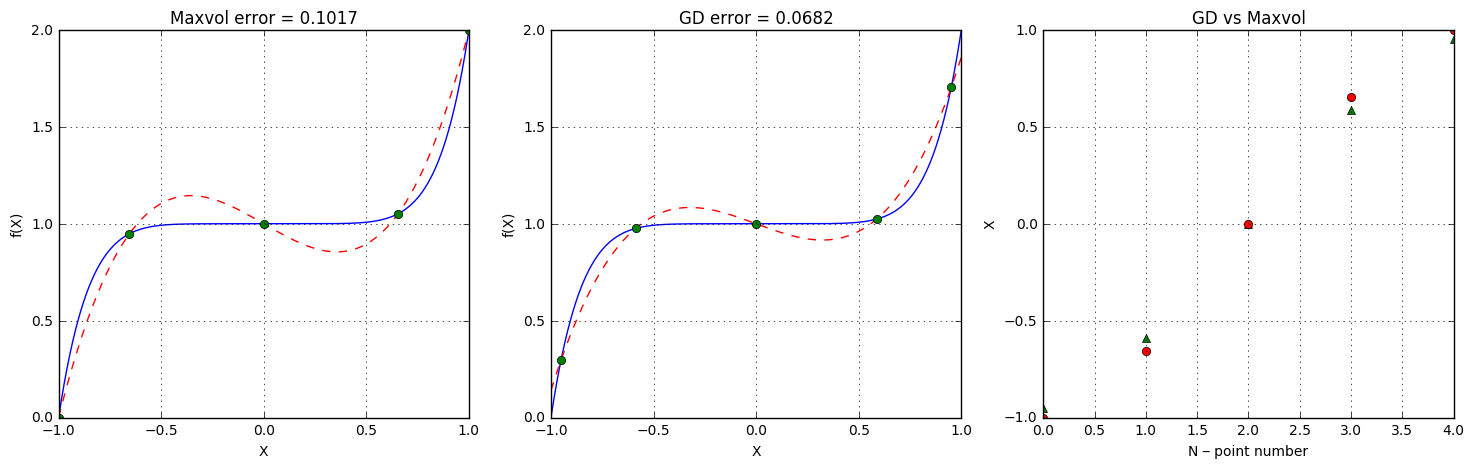

In [322]:
plot_and_err(np.sort(res[0]), np.sort(mat[row_indx, 1]), x_big)

In [323]:
LA.cond(gen_mat(np.sort(res[0]), degree))

1.4142145725454138